In [1]:
import json
import os
import torch
# Load the configuration from the JSON file
with open(r'C:\Users\Rishabh\Documents\3d-hcct\config.json', 'r') as f:
    config = json.load(f)

In [2]:
from model import ViTForClassfication

# Initialize the model with the loaded configuration
model = ViTForClassfication(config=config)

In [3]:
def count_parameters(model, trainable_only=True):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


In [4]:
from collections import OrderedDict
checkpoint_path = r'C:\Users\Rishabh\training_output_metricsHCCT_best_model.pth.tar'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint['state_dict']

# Remove 'module.' prefix if it exists
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')  # strip the prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict, strict=True)  # strict ensures all match


<All keys matched successfully>

In [5]:
total_params = count_parameters(model, trainable_only=False)
trainable = count_parameters(model, trainable_only=True)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable}")

Total parameters: 4715246
Trainable parameters: 4715246


In [6]:
import nibabel as nib
DataFolder = r'C:\Users\Rishabh\Documents\TrimeseData'
Files = os.listdir(DataFolder)

In [24]:
Attn = []
model.eval()
for file in Files:
    file_path = os.path.join(DataFolder, file)
    img = nib.load(file_path)
    x1 = img.get_fdata() 
    x1 = torch.from_numpy(x1)
    x1 = x1.unsqueeze(0).unsqueeze(0).float()
    with torch.no_grad():
        logits, all_attentions = model(x1, output_attentions=True)
    
    attn = torch.stack(all_attentions, dim=0)
    attn_mean = attn.mean(dim=0)
    avg_attn = attn_mean.mean(dim=1)
    avg_attn = avg_attn.mean(dim=0)

    Attn.append(avg_attn)
    print(avg_attn.shape)
    del x1, logits, all_attentions, attn, attn_mean, avg_attn
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
Attn = torch.mean(torch.stack(Attn), dim=0)
    

original x shape:-  torch.Size([1, 1, 91, 109, 91])
x1 shape:-  torch.Size([1, 32, 45, 54, 45])
x2 shape:-  torch.Size([1, 64, 22, 27, 22])
x3 shape:-  torch.Size([1, 128, 11, 13, 11])
x4 shape:-  torch.Size([1, 256, 5, 6, 5])
x before rearrange:-  torch.Size([1, 512, 2, 3, 2])
Final x shape(patch embedding):-  torch.Size([1, 512, 12])
cls_tokens:-  torch.Size([1, 1, 12])
Embedding shape:-   torch.Size([1, 513, 12])
query:-  torch.Size([1, 513, 1])
key:-  torch.Size([1, 513, 1])
value:-  torch.Size([1, 513, 1])
attention_output:-  torch.Size([1, 513, 1])
attention_probs:-  torch.Size([1, 513, 513])
query:-  torch.Size([1, 513, 1])
key:-  torch.Size([1, 513, 1])
value:-  torch.Size([1, 513, 1])
attention_output:-  torch.Size([1, 513, 1])
attention_probs:-  torch.Size([1, 513, 513])
query:-  torch.Size([1, 513, 1])
key:-  torch.Size([1, 513, 1])
value:-  torch.Size([1, 513, 1])
attention_output:-  torch.Size([1, 513, 1])
attention_probs:-  torch.Size([1, 513, 513])
query:-  torch.Size([1

In [48]:
att_mat = Attn
residual_att = torch.eye(att_mat.size(1)).to(device="cpu")
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device="cpu")
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

# Attention from the output token to the input space.
# v = joint_attentions[0,1:].to(device="cpu")
# v = joint_attentions[-1,1:].to(device="cpu")


# After the loop finishes:
final_rollout = joint_attentions[-1]      # shape [T, T], composed across all L layers
v = final_rollout[0]                      # CLS → all tokens, shape [T]
v_input_only = v[1:]                      # drop CLS token, shape [T-1]


IndexError: slice() cannot be applied to a 0-dim tensor.

In [50]:
v

tensor(0.0017)

In [42]:
joint_attentions[-1,1:] == aug_att_mat[0,1:]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [43]:
import cv2
print(len(v))
# mask = v.reshape(15, 13).detach().numpy()  # Attn1
mask = v.reshape(16, 32).detach().numpy()
mask = cv2.resize(mask / mask.max(), (91, 109))

512


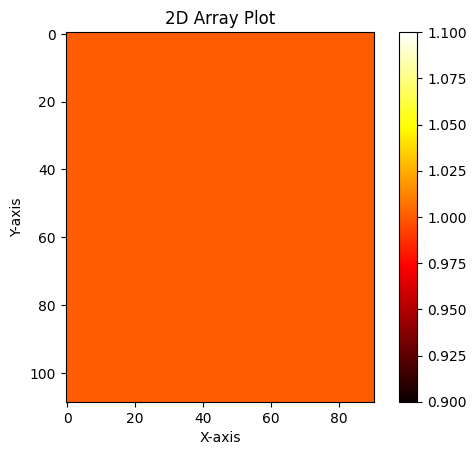

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array
array2d = mask

plt.imshow(array2d, cmap='hot')  # You can change cmap to 'gray', 'hot', etc.
plt.colorbar()  # Adds color scale legend
plt.title("2D Array Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [19]:
mask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
File_indx = 23
Sliceindx = 45
file_path = os.path.join(DataFolder, Files[File_indx])
img = nib.load(file_path)
img = img.get_fdata() 

Slice = img[Sliceindx,:, :]
Slice = Slice/1500
mask = mask*1000

overlayed_image = Slice*mask

In [ ]:
img[0,:, :].shape, mask.shape

In [ ]:
np.unique(img)

In [ ]:
np.unique(mask)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: create two dummy images
img1 = overlayed_image # Random grayscale image
img2 = Slice # Another random grayscale image

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot first image
# axes[0].imshow(img1, cmap='gray')
axes[0].imshow(img1)
axes[0].set_title('Image 1')
axes[0].axis('off')

# Plot second image
axes[1].imshow(img2)
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.tight_layout()
plt.show()
